In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K

In [ ]:
import sys
sys.path.append('Embeddings/pumap/')
from umap.parametric_umap import ParametricUMAP, load_ParametricUMAP

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

def plot_embedding(embedding, y_train, title=""):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    colors = [plt.cm.tab10.colors[i] for i in y_train]
    ax.scatter(embedding[:,0], embedding[:,1], c=colors, s=2)
    ax.set_aspect(1)
    recs = []
    for i in range(0,10):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
    ax.legend(recs,list(range(10)),loc=2)
    plt.title(title)
    plt.show()

# Datasets & Loaders

In [4]:
import pathlib
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data(
#     path='%s/data/mnist.npz'%pathlib.Path().absolute()
)

In [5]:
X_train = mnist_train[0][:,:,:,np.newaxis]
y_train = mnist_train[1]
X_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

In [6]:
X_test = mnist_test[0][:,:,:,np.newaxis]
y_test = mnist_test[1]
X_test.shape, y_test.shape

((10000, 28, 28, 1), (10000,))

# Classifier Network

In [7]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as nn

model = Sequential()
model.add(nn.InputLayer(input_shape=(28, 28, 1), name="in"))
model.add(nn.Conv2D(filters=6, kernel_size=5, activation='relu', name="conv1"))
model.add(nn.MaxPool2D(pool_size=2, name="pool1")) # 12x12x6 -> corresponds to conv1 in pytorch
model.add(nn.Conv2D(filters=16, kernel_size=5, activation='relu', name="conv2"))
model.add(nn.MaxPool2D(pool_size=2, name="pool2")) # 4x4x16 -> corresponds to conv2 in pytorch
model.add(nn.Flatten(name="flat")) # 16x4x4
model.add(nn.Dense(120, activation='relu', name="fc1"))
model.add(nn.Dense(100, activation='relu', name="fc2"))
model.add(nn.Dense(10, activation=None, name="fc3"))
# model.add(nn.Softmax(name="classifier")) # is needed in keras to properly train on categorical crossentropy loss (in pytorch the crossentropy loss takes logits as inputs)
# print(model.output_shape)

In [5]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as nn

model = Sequential()
model.add(nn.InputLayer(input_shape=(32, 32, 3), name="in"))
model.add(nn.Conv2D(filters=16, kernel_size=3, activation="relu", name="conv1"))
model.add(nn.Conv2D(filters=32, kernel_size=3, activation="relu", name="conv2"))
model.add(nn.MaxPool2D(pool_size=2, name="pool1"))
model.add(nn.Conv2D(filters=64, kernel_size=3, activation="relu", name="conv3"))
model.add(nn.MaxPool2D(pool_size=2, name="pool2"))
model.add(nn.Conv2D(filters=128, kernel_size=3, activation="relu", name="conv4"))
model.add(nn.MaxPool2D(pool_size=2, name="pool3"))
model.add(nn.Dropout(0.2, name="drop"))
model.add(nn.Flatten(name="flat"))
model.add(nn.Dense(10, activation=None, name="classifier"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 30, 30, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 12, 12, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv4 (Conv2D)               (None, 4, 4, 128)         73856     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 2, 2, 128)        

In [8]:
# model.summary()

# Train Initial Network

In [9]:
epochs = 5
# tf.random.set_seed(42)

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), #tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),  # sgd does not work with this keras model (it works at least a bit, if lr=0.001)
    # Loss function to minimize
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=['accuracy'],
)

history = model.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=epochs,
    shuffle=True
)

Epoch 1/5
1200/1200 [==============================] - 22s 18ms/step - loss: 0.5014 - accuracy: 0.9094
Epoch 2/5
1200/1200 [==============================] - 22s 18ms/step - loss: 0.1038 - accuracy: 0.9690
Epoch 3/5
1200/1200 [==============================] - 21s 18ms/step - loss: 0.0763 - accuracy: 0.9773
Epoch 4/5
1200/1200 [==============================] - 22s 18ms/step - loss: 0.0630 - accuracy: 0.9802
Epoch 5/5
1200/1200 [==============================] - 22s 18ms/step - loss: 0.0569 - accuracy: 0.9828


In [11]:
model.save('models/mnist-before.h5')

# Embedding

In [12]:
layer_key = 'fc2' # which latent layer output should be used for embedding
# embedding_size = 10 # what's the output size of this layer
#embedding_dim = None#(10) # what is the output dimension

In [13]:
model = tf.keras.models.load_model("models/mnist-before.h5")

In [14]:
model_sub = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer(layer_key).output)
# model_sub.summary()

In [15]:
logits_train = model_sub(X_train)
logits_test = model_sub(X_test)

In [16]:
# logits_train.shape

In [17]:
import numpy as np
# tf.random.set_seed(42)

embedder = ParametricUMAP(optimizer=tf.keras.optimizers.Adam(),
        batch_size=500,
        dims=None,
        encoder=None, # you could enter another network here
        loss_report_frequency=10,
        n_training_epochs=1,
        verbose=True)
embedder.fit(logits_train[::12]) # why is only subset used?

ParametricUMAP(batch_size=500,
               optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000000BE09141CA0>)
Construct fuzzy simplicial set
Tue Oct 20 13:19:54 2020 Finding Nearest Neighbors
Tue Oct 20 13:19:54 2020 Building RP forest with 9 trees
Tue Oct 20 13:19:56 2020 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	Stopping threshold met -- exiting after 3 iterations
Tue Oct 20 13:20:16 2020 Finished Nearest Neighbor Search
Tue Oct 20 13:20:20 2020 Construct embedding


Embeddings/pumap\umap\parametric_umap.py:270: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  warn(


Epoch 1/10
132/132 [==============================] - 1s 10ms/step - loss: 0.2277
Epoch 2/10
132/132 [==============================] - 2s 15ms/step - loss: 0.1897
Epoch 3/10
132/132 [==============================] - 2s 17ms/step - loss: 0.1810
Epoch 4/10
132/132 [==============================] - 2s 18ms/step - loss: 0.1749
Epoch 5/10
132/132 [==============================] - 2s 18ms/step - loss: 0.1721
Epoch 6/10
132/132 [==============================] - 2s 16ms/step - loss: 0.1696
Epoch 7/10
132/132 [==============================] - 2s 15ms/step - loss: 0.1637
Epoch 8/10
132/132 [==============================] - 2s 14ms/step - loss: 0.1627
Epoch 9/10
132/132 [==============================] - 3s 20ms/step - loss: 0.1596
Epoch 10/10
157/157 [==============================] - 0s 952us/step
Tue Oct 20 13:20:44 2020 Finished embedding


ParametricUMAP(batch_size=500, dims=[100],
               encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x000000BE0C36F0A0>,
               optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000000BE09141CA0>)

In [18]:
embedder.save('models/mnist-pumap')

models/mnist-pumap\encoder_model.h5
Keras encoder model saved to models/mnist-pumap\encoder_model.h5
Keras full model saved to models/mnist-pumap\parametric_model.h5
Tue Oct 20 13:20:51 2020 Worst tree score: 0.86520000
Tue Oct 20 13:20:51 2020 Mean tree score: 0.87517778
Tue Oct 20 13:20:51 2020 Best tree score: 0.88740000
Tue Oct 20 13:20:56 2020 Forward diversification reduced edges from 75000 to 27247
Tue Oct 20 13:21:01 2020 Reverse diversification reduced edges from 27247 to 27247
Tue Oct 20 13:21:04 2020 Degree pruning reduced edges from 27892 to 27892
Tue Oct 20 13:21:04 2020 Resorting data and graph based on tree order
Tue Oct 20 13:21:04 2020 Compressing index by removing unneeded attributes
Tue Oct 20 13:21:04 2020 Building and compiling search function
Tue Oct 20 13:21:07 2020 Building and compiling search function
Pickle of ParametricUMAP model saved to models/mnist-pumap\model.pkl


In [19]:
projected_train = embedder.encoder(logits_train)
projected_test = embedder.encoder(logits_test)

# Determine Suitable Shifts

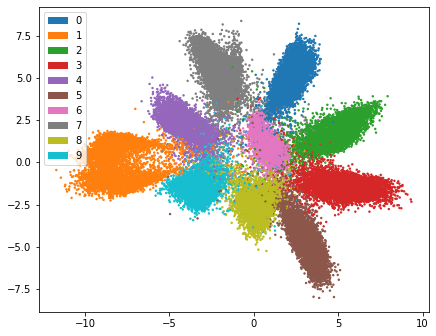

In [20]:
plot_embedding(projected_train, y_train)

In [21]:
labels_train = y_train
shifted_train = projected_train.numpy()

for i in range(10):
    shifted_train[labels_train == i] = (1./2. * shifted_train[(labels_train == i)] + 1./4. * shifted_train[(labels_train == i)].mean(axis=0)) + np.array([0.,0.])

In [22]:
# shifted_train[labels_train == 9] += torch.tensor([7.,7.])
# shifted_train[labels_train == 4] += torch.tensor([-2.,7.])

In [23]:
# labels_train = mnist_train.targets
# shifted_train = projected_train.clone()
# shifted_train[labels_train == 3] = (1./2. * projected_train[(labels_train == 3)] + 1./4. * projected_train[(labels_train == 3)].mean(axis=0)) + torch.tensor([-10.,-7.])
# shifted_train[labels_train == 8] = (3./4. * projected_train[(labels_train == 8)] + 1./4. * projected_train[(labels_train == 8)].mean(axis=0)) + torch.tensor([3.,3.])
# shifted_train[labels_train == 4] = (1./2. * projected_train[(labels_train == 4)] + 1./4. * projected_train[(labels_train == 4)].mean(axis=0)) + torch.tensor([7.,-10.])

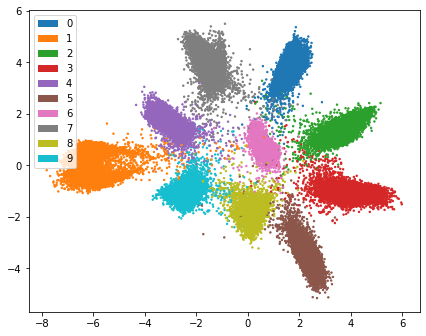

In [24]:
plot_embedding(shifted_train, y_train)

# Retraining

In [25]:
epochs = 4
# tf.random.set_seed(42)

In [26]:
model_classifier = tf.keras.models.load_model("models/mnist-before.h5")
embedder = load_ParametricUMAP('models/mnist-pumap')
model_embedder = embedder.encoder

Tue Oct 20 13:21:13 2020 Building and compiling search function
Pickle of ParametricUMAP model loaded from models/mnist-pumap\model.pkl
Keras encoder model loaded from models/mnist-pumap\encoder_model.h5
Keras full model loaded from models/mnist-pumap\parametric_model.h5


In [27]:
model_embedder = tf.keras.Model(model_embedder.inputs, model_embedder.outputs, name="embedder")
model_embedder.summary()

Model: "embedder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
z (Dense)                    (None, 2)                 202       
Total params: 30,502
Trainable params: 30,502
Non-trainable params: 0
______________________________________________________

In [28]:
# we do not want to train the embedding network!
model_embedder.trainable = False

In [29]:
embedder_out = model_embedder(model_classifier.get_layer(layer_key).output)
model_comb = tf.keras.Model(model_classifier.input, [model_classifier.output, embedder_out])
# model_comb.summary()

In [30]:
# train network using the altered embedded points
model_comb.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), #tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),  # sgd does not work with this keras model (it works at least a bit, if lr=0.001)
    # Loss function to minimize
    loss={"classifier": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "embedder": tf.keras.losses.MeanSquaredError()},
    loss_weights={"classifier": 1.0, "embedder": 1.0},
    # List of metrics to monitor
    metrics={"classifier": ['accuracy']},
)

history = model_comb.fit(
    x=X_train,
    y={"classifier": y_train, "embedder": shifted_train},
    batch_size=50,
    epochs=epochs,
    shuffle=True
)

model_comb.save('models/mnist-after.h5')

Epoch 1/4


ValueError: in user code:

    C:\Users\Gini\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Gini\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Gini\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Gini\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Gini\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Gini\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Gini\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    C:\Users\Gini\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\compile_utils.py:183 __call__
        y_true = self._conform_to_outputs(y_pred, y_true)
    C:\Users\Gini\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\compile_utils.py:63 _conform_to_outputs
        struct = map_to_output_names(outputs, self._output_names, struct)
    C:\Users\Gini\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\compile_utils.py:586 map_to_output_names
        raise ValueError('Found unexpected keys that do not correspond '

    ValueError: Found unexpected keys that do not correspond to any Model output: dict_keys(['classifier']). Expected: ['fc3', 'embedder']


In [ ]:
# train network as usual, for better comparability
model_classifier = tf.keras.models.load_model("models/mnist-before.h5")
model_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), #tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),  # sgd does not work with this keras model (it works at least a bit, if lr=0.001)
    # Loss function to minimize
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=['accuracy'],
)
history = model_classifier.fit(
    x=X_train,
    y= y_train,
    batch_size=50,
    epochs=epochs,
    shuffle=True
)

model_classifier.save('models/mnist-after-baseline.h5')

#### calculate output for train and test sets over all methods

In [ ]:
# outputs for initial model (trained for 5 epochs)
model_classifier = tf.keras.models.load_model("models/mnist-before.h5")
model_sub = tf.keras.Model(inputs=model_classifier.inputs, outputs=model_classifier.get_layer(layer_key).output)
embedder = load_ParametricUMAP('models/mnist-pumap')
model_embedder = embedder.encoder

logits_train_before = model_classifier(X_train)
projected_train_before = model_embedder(model_sub(X_train))
logits_test_before = model_classifier(X_test)
projected_test_before = model_embedder(model_sub(X_test))


In [ ]:
# outputs for baseline model (trained for 5 + 4 epochs)
model_classifier = tf.keras.models.load_model("models/mnist-after-baseline.h5")
model_sub = tf.keras.Model(inputs=model_classifier.inputs, outputs=model_classifier.get_layer(layer_key).output)
embedder = load_ParametricUMAP('models/mnist-pumap')
model_embedder = embedder.encoder

logits_train_baseline = model_classifier(X_train)
projected_train_baseline = model_embedder(model_sub(X_train))
logits_test_baseline = model_classifier(X_test)
projected_test_baseline = model_embedder(model_sub(X_test))


In [ ]:
# outputs for model using latent interventions (trained for 5 + 4 epochs)
model_combined = tf.keras.models.load_model("models/mnist-after.h5")

logits_train_after, projected_train_after = model_combined(X_train)
logits_test_after, projected_test_after = model_combined(X_test)


# Evaluation

In [ ]:
plot_embedding(projected_train_baseline[::12], y_train[::12], "Projected Baseline")

In [ ]:
plot_embedding(projected_train_after[::12], y_train[::12], "Projected Network using Latent Space Interventions")

In [ ]:
def get_cf(y, logits):
    cf = np.zeros((10,10), dtype="int64")
    for i in zip(y, logits.numpy().argmax(1)):
        cf[i] += 1
    return cf

In [ ]:
cf_train_before = get_cf(y_train, logits_train_before)

cf_test_before = get_cf(y_test, logits_test_before)

In [ ]:
cf_train_baseline = get_cf(y_train, logits_train_baseline)

cf_test_baseline = get_cf(y_test, logits_test_baseline)

In [ ]:
cf_train_altered = get_cf(y_train, logits_train_after)

cf_test_altered = get_cf(y_test, logits_test_after)

In [ ]:
# baseline accuracy
np.diag(cf_test_baseline).sum() / cf_test_baseline.sum()

In [ ]:
# intervention accuracy
np.diag(cf_test_altered).sum() / cf_test_altered.sum()

In [ ]:
cf_test_before

In [ ]:
cf_test_baseline

In [ ]:
cf_test_altered

In [ ]:
def prec(cf, l):
    return cf[l,l] / cf[:,l].sum()
def rec(cf, l):
    return cf[l,l] / cf[l,:].sum()
def f1(cf, l):
    return 2 * prec(cf, l) * rec(cf, l) / (prec(cf, l) + rec(cf, l))

In [ ]:
# print(prec(cf_test_baseline, 3))
# print(rec(cf_test_baseline, 3))
# print(f1(cf_test_baseline, 3))

# print(prec(cf_test_baseline, 8))
# print(rec(cf_test_baseline, 8))
# print(f1(cf_test_baseline, 8))

print(f1(cf_test_baseline, 4))
print(f1(cf_test_baseline, 9))

In [ ]:
# print(prec(cf_test_altered, 3))
# print(rec(cf_test_altered, 3))
# print(f1(cf_test_altered, 3))

# print(prec(cf_test_altered, 8))
# print(rec(cf_test_altered, 8))
# print(f1(cf_test_altered, 8))

print(f1(cf_test_altered, 4))
print(f1(cf_test_altered, 9))